In [1]:
#today, we will put together a fun plot
import os
import glob
import subprocess
import matplotlib.pyplot as plt
import pandas as pd
import math
from numpy import *
from pylab import *

import pyproj
import metpy.calc as mpcalc
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.crs as crs
from cartopy.geodesic import Geodesic
from cartopy.feature import NaturalEarthFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import wrf
from wrf import (to_np, interplevel, geo_bounds, getvar, smooth2d, get_cartopy, cartopy_xlim,
                 cartopy_ylim, latlon_coords)
import shutil

# Download state and coastline data
states = NaturalEarthFeature(category="cultural", scale="50m",
                          facecolor="none", name="admin_1_states_provinces_shp")
from scipy.interpolate import RegularGridInterpolator
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
import matplotlib.ticker as mticker
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import ScalarFormatter
from scipy.ndimage import gaussian_filter

import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from netCDF4 import Dataset, num2date, date2num
from datetime import datetime
from PIL import Image

#for color scale
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap, to_rgba

In [2]:
#First, Specifiy File path
filepath_wrfout = '/glade/derecho/scratch/cmasiello/nest_following_version/WRFV4.5.2/test/em_real_72km_18ms/wrfout_d03*' 
datafiles_wrfout = sorted(glob.glob(filepath_wrfout))

In [3]:
# set some constants for later use that we may or may not use, just there for any meteorological claculation you may conduct
deltap     = 5000.        # vertical isobaric spacing
resol      = 0.5          # degrees
pref       = 100000.      # Pa
cv         = 717.         # J kg-1 K-1
cp         = 1004.7       # J kg-1 K-1
omega      = 7.292e-5     # Rotation rate s-1       
rd         = 287.04       # J kg-1 K-1
fo         = 1.0e-4       # s-1; assume constant Coriolis parameter (Eliassen 1962)
po         = 100000.      # standard pressure (Pa)
r_earth    = 6.3781e6     # meters (Earth Radius)
grav       = 9.80665      # m/s-2
d2r        = (np.pi)/180. # degrees to radians
rv         = 461.50
k          = 0.4          #Von Karmen Constant

def find_nearest(a, val):
    return np.abs(a - val).argmin()

In [5]:
olr = []

#Here we will calculate the inertial stability of our simulations
for item in range(1,len(datafiles_wrfout)):
    ncfile = Dataset(datafiles_wrfout[item])
    wrf_out_data = xr.open_dataset(datafiles_wrfout[item])
    
    Time = wrf.extract_times(ncfile, timeidx=0, method='cat', squeeze=True, cache=None, meta=False, do_xtime=False)
    timestr=(str(Time))
    
    # Set up one time string for plot titles, another for file names
    titletime=(timestr[0:10]+' '+timestr[11:16])
    filetime=(timestr[0:10]+'_'+timestr[11:13])
    print('WRF valid time: ',filetime, titletime, timestr)
    
    #Get constant variables
    lat = getvar(ncfile, "XLAT")
    lon = getvar(ncfile, "XLONG")
    ny, nx = lat.shape
    ###############################################################################################
    #Next, isolate the variable we care to look at, in this case we will only care about the pressure pertubations
    P_pertubation = wrf_out_data['P']
    surface_P_pertubation = P_pertubation[0,0,:,:]
    
    #Apply a Gaussian filter to smooth the pressure field
    smoothed_pressure = gaussian_filter(surface_P_pertubation, sigma=10)  # Adjust sigma as necessary

    #Now find the minimum pressure in the smoothed field
    minpressure_smoothed = np.min(smoothed_pressure)
    
    #print(minpressure_smoothed)
    minp_smoothed = minpressure_smoothed

    # Get the index of the minimum pressure
    p_index_smoothed = np.argwhere(smoothed_pressure == minp_smoothed)
    s_n_smoothed = p_index_smoothed[0][0]
    w_e_smoothed = p_index_smoothed[0][1]

    # Update the storm center position
    ypos = s_n_smoothed
    xpos = w_e_smoothed

    tc_lon = wrf_out_data['XLONG'][0,s_n_smoothed,w_e_smoothed].values
    tc_lat = wrf_out_data['XLAT'][0,s_n_smoothed,w_e_smoothed].values
    ##############################################################################################
    #IR brightness temperature
    wrf_out_OLR =  wrf_out_data['OLR'][0,:,:]
    wrf_out_OLR_T = -273.15 + (wrf_out_OLR.values + 310)/2
    ##############################################################################################
    #First, we have to create lists
    ydist, xdist, tcdist, rlonfac, theta_ang = [np.zeros([ny,nx]) for _ in range(5)]
   
    #compute distance from each grid point to storm center
    rlonfac[:,:] = 111000.*np.cos(d2r*lat[:,:])
    ydist[:,:]   = (lat[:,:] - lat[ypos,xpos])*111000
    xdist[:,:]   = (lon[:,:] - (lon[ypos,xpos]))*rlonfac
    tcdist[:,:]  = (xdist[:,:]**2 + ydist[:,:]**2)**0.5
    
    #cvalculate angle
    theta_ang = np.arctan2(ydist, xdist)
    angles_deg = np.degrees(theta_ang) % 360
    
    #Pre-calculate cos and sin of theta_ang for use in vectorized calculations
    cos_theta = np.cos(theta_ang)
    sin_theta = np.sin(theta_ang)
    ##############################################################################################
    #Azimuthal average by binning.  Need to specify grid point of storm center, and have arrays for lat, lon
    #Could also set up to specify lat/lon of storm center
    binnum  = 376      #this lets us look at 500 kilometers away from the TC center
    binsize = 1
    dx      = 1333.   #Horizontal grid size of our domain in meters
    
    xlabs = ['']*binnum

    pvbin, wabin, windbin, olr_bin           = [np.zeros([ny,nx]) for _ in range(4)]
    #pvazavg, waazavg, windzavg     = [np.zeros([n_zlevs-1,int(binnum/binsize)]) for _ in range(4)]
    olraavg = np.zeros([int(binnum/binsize)])
    
    for j in range (0, binnum, binsize):
        binmin = j*dx
        binmax = (j+binsize)*dx
        bincnt = int(j/binsize)
        
        xlabs[j] = str(bincnt*12)

        #Calculate the azimuthal average of the 2d variable 
        olr_bin[:,:] = np.where(((tcdist[:,:] > binmin) & (tcdist[:,:] < binmax)), wrf_out_OLR_T[:,:], np.nan)

        olraavg[bincnt] = np.nanmean(olr_bin[:,:])

    olr.append(olraavg)

WRF valid time:  2007-08-18_01 2007-08-18 01:00 2007-08-18T01:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_02 2007-08-18 02:00 2007-08-18T02:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_03 2007-08-18 03:00 2007-08-18T03:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_04 2007-08-18 04:00 2007-08-18T04:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_05 2007-08-18 05:00 2007-08-18T05:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_06 2007-08-18 06:00 2007-08-18T06:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_07 2007-08-18 07:00 2007-08-18T07:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_08 2007-08-18 08:00 2007-08-18T08:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_09 2007-08-18 09:00 2007-08-18T09:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_10 2007-08-18 10:00 2007-08-18T10:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_11 2007-08-18 11:00 2007-08-18T11:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_12 2007-08-18 12:00 2007-08-18T12:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_13 2007-08-18 13:00 2007-08-18T13:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_14 2007-08-18 14:00 2007-08-18T14:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_15 2007-08-18 15:00 2007-08-18T15:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_16 2007-08-18 16:00 2007-08-18T16:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_17 2007-08-18 17:00 2007-08-18T17:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_18 2007-08-18 18:00 2007-08-18T18:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_19 2007-08-18 19:00 2007-08-18T19:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_20 2007-08-18 20:00 2007-08-18T20:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_21 2007-08-18 21:00 2007-08-18T21:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_22 2007-08-18 22:00 2007-08-18T22:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-18_23 2007-08-18 23:00 2007-08-18T23:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_00 2007-08-19 00:00 2007-08-19T00:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_01 2007-08-19 01:00 2007-08-19T01:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_02 2007-08-19 02:00 2007-08-19T02:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_03 2007-08-19 03:00 2007-08-19T03:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_04 2007-08-19 04:00 2007-08-19T04:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_05 2007-08-19 05:00 2007-08-19T05:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_06 2007-08-19 06:00 2007-08-19T06:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_07 2007-08-19 07:00 2007-08-19T07:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_08 2007-08-19 08:00 2007-08-19T08:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_09 2007-08-19 09:00 2007-08-19T09:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_10 2007-08-19 10:00 2007-08-19T10:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_11 2007-08-19 11:00 2007-08-19T11:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_12 2007-08-19 12:00 2007-08-19T12:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_13 2007-08-19 13:00 2007-08-19T13:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_14 2007-08-19 14:00 2007-08-19T14:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_15 2007-08-19 15:00 2007-08-19T15:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_16 2007-08-19 16:00 2007-08-19T16:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_17 2007-08-19 17:00 2007-08-19T17:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_18 2007-08-19 18:00 2007-08-19T18:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_19 2007-08-19 19:00 2007-08-19T19:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_20 2007-08-19 20:00 2007-08-19T20:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_21 2007-08-19 21:00 2007-08-19T21:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_22 2007-08-19 22:00 2007-08-19T22:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-19_23 2007-08-19 23:00 2007-08-19T23:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_00 2007-08-20 00:00 2007-08-20T00:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_01 2007-08-20 01:00 2007-08-20T01:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_02 2007-08-20 02:00 2007-08-20T02:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_03 2007-08-20 03:00 2007-08-20T03:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_04 2007-08-20 04:00 2007-08-20T04:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_05 2007-08-20 05:00 2007-08-20T05:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_06 2007-08-20 06:00 2007-08-20T06:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_07 2007-08-20 07:00 2007-08-20T07:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_08 2007-08-20 08:00 2007-08-20T08:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_09 2007-08-20 09:00 2007-08-20T09:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_10 2007-08-20 10:00 2007-08-20T10:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_11 2007-08-20 11:00 2007-08-20T11:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_12 2007-08-20 12:00 2007-08-20T12:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_13 2007-08-20 13:00 2007-08-20T13:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_14 2007-08-20 14:00 2007-08-20T14:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_15 2007-08-20 15:00 2007-08-20T15:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_16 2007-08-20 16:00 2007-08-20T16:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_17 2007-08-20 17:00 2007-08-20T17:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_18 2007-08-20 18:00 2007-08-20T18:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_19 2007-08-20 19:00 2007-08-20T19:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_20 2007-08-20 20:00 2007-08-20T20:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_21 2007-08-20 21:00 2007-08-20T21:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_22 2007-08-20 22:00 2007-08-20T22:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-20_23 2007-08-20 23:00 2007-08-20T23:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


WRF valid time:  2007-08-21_00 2007-08-21 00:00 2007-08-21T00:00:00.000000000


/glade/derecho/scratch/cmasiello/tmp/ipykernel_244897/3408773778.py:89: RuntimeWarning: Mean of empty slice
  olraavg[bincnt] = np.nanmean(olr_bin[:,:])


In [8]:
#Creating IR color Scale
def make_Ramp(ramp_colors):
    color_ramp = LinearSegmentedColormap.from_list('my_list', ramp_colors)
    plt.figure(figsize=(15, 3))
    plt.imshow([list(np.arange(0, len(ramp_colors), 0.1))], interpolation='nearest', origin='lower', cmap=color_ramp)
    plt.xticks([])
    plt.yticks([])
    return color_ramp

custom_ramp = make_Ramp([
        "#00000a","#000014","#00001e","#000025","#00002a","#00002e","#000032","#000036","#00003a","#00003e",
        "#000042","#000046","#00004a","#00004f","#000052","#010055","#010057","#020059","#02005c","#03005e",
        "#040061","#040063","#050065","#060067","#070069","#08006b","#09006e","#0a0070","#0b0073","#0c0074",
        "#0d0075","#0d0076","#0e0077","#100078","#120079","#13007b","#15007c","#17007d","#19007e","#1b0080",
        "#1c0081","#1e0083","#200084","#220085","#240086","#260087","#280089","#2a0089","#2c008a","#2e008b",
        "#30008c","#32008d","#34008e","#36008e","#38008f","#390090","#3b0091","#3c0092","#3e0093","#3f0093",
        "#410094","#420095","#440095","#450096","#470096","#490096","#4a0096","#4c0097","#4e0097","#4f0097",
        "#510097","#520098","#540098","#560098","#580099","#5a0099","#5c0099","#5d009a","#5f009a","#61009b",
        "#63009b","#64009b","#66009b","#68009b","#6a009b","#6c009c","#6d009c","#6f009c","#70009c","#71009d",
        "#73009d","#75009d","#77009d","#78009d","#7a009d","#7c009d","#7e009d","#7f009d","#81009d","#83009d",
        "#84009d","#86009d","#87009d","#89009d","#8a009d","#8b009d","#8d009d","#8f009c","#91009c","#93009c",
        "#95009c","#96009b","#98009b","#99009b","#9b009b","#9c009b","#9d009b","#9f009b","#a0009b","#a2009b",
        "#a3009b","#a4009b","#a6009a","#a7009a","#a8009a","#a90099","#aa0099","#ab0099","#ad0099","#ae0198",
        "#af0198","#b00198","#b00198","#b10197","#b20197","#b30196","#b40296","#b50295","#b60295","#b70395",
        "#b80395","#b90495","#ba0495","#ba0494","#bb0593","#bc0593","#bd0593","#be0692","#bf0692","#bf0692",
        "#c00791","#c00791","#c10890","#c10990","#c20a8f","#c30a8e","#c30b8e","#c40c8d","#c50c8c","#c60d8b",
        "#c60e8a","#c70f89","#c81088","#c91187","#ca1286","#ca1385","#cb1385","#cb1484","#cc1582","#cd1681",
        "#ce1780","#ce187e","#cf187c","#cf197b","#d01a79","#d11b78","#d11c76","#d21c75","#d21d74","#d31e72",
        "#d32071","#d4216f","#d4226e","#d5236b","#d52469","#d62567","#d72665","#d82764","#d82862","#d92a60",
        "#da2b5e","#da2c5c","#db2e5a","#db2f57","#dc2f54","#dd3051","#dd314e","#de324a","#de3347","#df3444",
        "#df3541","#df363d","#e0373a","#e03837","#e03933","#e13a30","#e23b2d","#e23c2a","#e33d26","#e33e23",
        "#e43f20","#e4411d","#e4421c","#e5431b","#e54419","#e54518","#e64616","#e74715","#e74814","#e74913",
        "#e84a12","#e84c10","#e84c0f","#e94d0e","#e94d0d","#ea4e0c","#ea4f0c","#eb500b","#eb510a","#eb520a",
        "#eb5309","#ec5409","#ec5608","#ec5708","#ec5808","#ed5907","#ed5a07","#ed5b06","#ee5c06","#ee5c05",
        "#ee5d05","#ee5e05","#ef5f04","#ef6004","#ef6104","#ef6204","#f06303","#f06403","#f06503","#f16603",
        "#f16603","#f16703","#f16803","#f16902","#f16a02","#f16b02","#f16b02","#f26c01","#f26d01","#f26e01",
        "#f36f01","#f37001","#f37101","#f37201","#f47300","#f47400","#f47500","#f47600","#f47700","#f47800",
        "#f47a00","#f57b00","#f57c00","#f57e00","#f57f00","#f68000","#f68100","#f68200","#f78300","#f78400",
        "#f78500","#f78600","#f88700","#f88800","#f88800","#f88900","#f88a00","#f88b00","#f88c00","#f98d00",
        "#f98d00","#f98e00","#f98f00","#f99000","#f99100","#f99200","#f99300","#fa9400","#fa9500","#fa9600",
        "#fb9800","#fb9900","#fb9a00","#fb9c00","#fc9d00","#fc9f00","#fca000","#fca100","#fda200","#fda300",
        "#fda400","#fda600","#fda700","#fda800","#fdaa00","#fdab00","#fdac00","#fdad00","#fdae00","#feaf00",
        "#feb000","#feb100","#feb200","#feb300","#feb400","#feb500","#feb600","#feb800","#feb900","#feb900",
        "#feba00","#febb00","#febc00","#febd00","#febe00","#fec000","#fec100","#fec200","#fec300","#fec400",
        "#fec500","#fec600","#fec700","#fec800","#fec901","#feca01","#feca01","#fecb01","#fecc02","#fecd02",
        "#fece03","#fecf04","#fecf04","#fed005","#fed106","#fed308","#fed409","#fed50a","#fed60a","#fed70b",
        "#fed80c","#fed90d","#ffda0e","#ffda0e","#ffdb10","#ffdc12","#ffdc14","#ffdd16","#ffde19","#ffde1b",
        "#ffdf1e","#ffe020","#ffe122","#ffe224","#ffe226","#ffe328","#ffe42b","#ffe42e","#ffe531","#ffe635",
        "#ffe638","#ffe73c","#ffe83f","#ffe943","#ffea46","#ffeb49","#ffeb4d","#ffec50","#ffed54","#ffee57",
        "#ffee5b","#ffee5f","#ffef63","#ffef67","#fff06a","#fff06e","#fff172","#fff177","#fff17b","#fff280",
        "#fff285","#fff28a","#fff38e","#fff492","#fff496","#fff49a","#fff59e","#fff5a2","#fff5a6","#fff6aa",
        "#fff6af","#fff7b3","#fff7b6","#fff8ba","#fff8bd","#fff8c1","#fff8c4","#fff9c7","#fff9ca","#fff9cd",
        "#fffad1","#fffad4","#fffbd8","#fffcdb","#fffcdf","#fffde2","#fffde5","#fffde8","#fffeeb","#fffeee",
        "#fffef1","#fffef4","#fffff6"])

top = custom_ramp
bottom = plt.get_cmap('Greys', 128)

newcolors = np.vstack((top(np.linspace(0, 1, 66)), bottom(np.linspace(0, 1, 33))))

newcmp = ListedColormap(newcolors, name='Cam_Cool_Color_Scale')

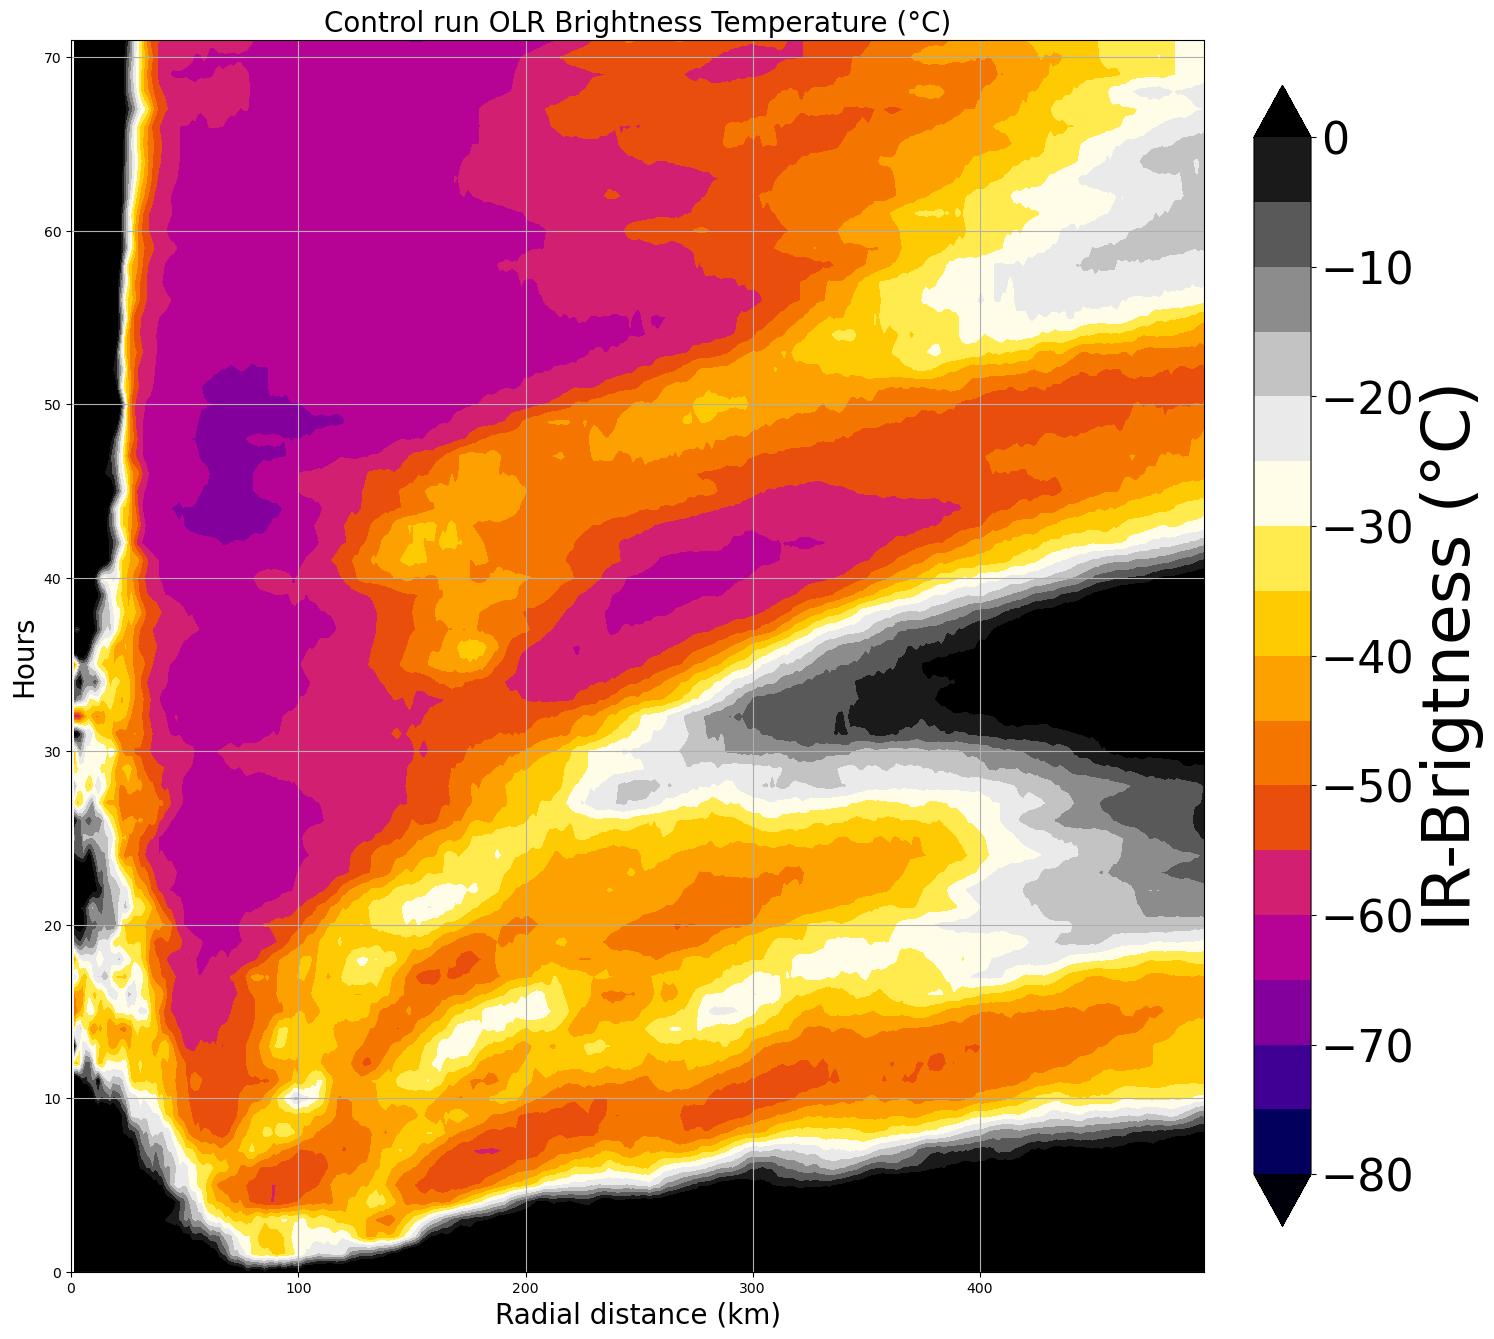

In [10]:
#Define the levels you want for the contours
levels = levels=np.arange(-80, 5, 5)

#Create a figure and axis
fig, ax = plt.subplots(figsize=(16, 16))

#If each grid space represents 4 km, create an array that reflects the actual distance
radial_distance = np.arange(0, binnum*1.33, 1.33)  # This assumes binnum grid cells, 4 km apart

#If each grid space represents 3 hrs, create an array that reflects the actual time
time = np.arange(0, len(olr)*1, 1)  # This assumes binnum grid cells, 3 hours apart

#Create the contourf plot with the specified levels
contourf_plot = ax.contourf(radial_distance, time, olr, levels=levels, cmap=newcmp, origin='lower', extend = 'both')

cbar2 = fig.colorbar(contourf_plot, fraction=0.046, pad=0.04)
cbar2.set_label(r'IR-Brigtness (°C)', fontsize=48)
cbar2.ax.tick_params(labelsize=32)

#Set axis labels and title
ax.set_xlabel('Radial distance (km)', fontsize=20)
ax.set_ylabel('Hours', fontsize=20)
ax.set_title('Control run OLR Brightness Temperature (°C)', fontsize=20)

#Set the axis limits
ax.set_xlim(0, radial_distance.max())
ax.set_ylim(0, time.max())
ax.grid(True)

plt.show()